# Project for the "Big Data Computing" course, a.y. 2021/2022
## Alessio Palma 1837493 - Davide Santoro 1843664

If you are running this on Paperspace's Gradient, please execute the following cel to prettify the output of Gradient notebooks cells:

In [ ]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# **Global Constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
DATASET_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATASET_FILE = "data/" + DATASET_URL.split("/")[-1]

RANDOM_SEED = 3 # for reproducibility

# **Spark setup**

## Install PySpark and related dependencies


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install -y openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME
!pip install torch torchvision torchaudio
!pip install tensorboard
!pip install pytorch-lightning
!pip install horovod[spark]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 62.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=8a22609ec5f3b25b02b85e7c1d5cf6fcde0b4a303c889a32a50a3008dabaff7c
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

Create two folders that will be useful in the future and delete trailing parenthesis at row 494 of estimator.py from Horovod on Spark (it is a bug, as reported [here](https://github.com/horovod/horovod/issues/2696)). On Colab you can open the file by CTRL + click on the path of the file, then modify by hand:

In [ ]:
!mkdir data
!mkdir hvdstore
!ls -l /usr/local/lib/python3.7/dist-packages/horovod/spark/torch/estimator.py

-rw-r--r-- 1 root root 22019 Jul 27 10:44 /usr/local/lib/python3.7/dist-packages/horovod/spark/torch/estimator.py


## Import Python packages

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import random
import csv
import gc

import pyspark
import pyspark.sql.types as T
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, array, sum, mean, split, explode, countDistinct, from_unixtime, dayofweek
from pyspark import SparkContext, SparkConf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

import torch
from torch import nn
import horovod.spark.torch as hvd
from horovod.spark.common.store import Store

## Create spark context

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G').set("spark.ui.showConsoleProgress", "false")

# create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()
sc.setLogLevel("ERROR")

## Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.port', '33491'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.id', 'local-1658870713508'),
 ('spark.ui.showConsoleProgress', 'false'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spa

# Our dataset
We are using the MovieLens 1M Dataset from [GroupLens](https://grouplens.org/datasets/movielens/), which periodically collects and makes available rating datasets from [MovieLens](https://movielens.org). This datasets are specifically suited for recommender systems, ours contains 1 million movie ratings from more than 6000 users on almost 4000 movies.

## Data Collection

This is the first step we need to accomplish. First we download the dataset file from the URL directly to our machine, then we unzip it.

In [ ]:
def get_data(dataset_url, dest, chunk_size=1024):
    response = requests.get(dataset_url, stream=True)
    if response.status_code == 200:
        with open(dest, "wb") as file:
            for block in response.iter_content(chunk_size=chunk_size): 
                if block: 
                    file.write(block)

In [ ]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(DATASET_FILE))

!unzip -u "data/ml-1m.zip" -d "data/"

Retrieving dataset from URL: https://files.grouplens.org/datasets/movielens/ml-1m.zip ...
Dataset successfully retrieved and stored at: data/ml-1m.zip
Archive:  data/ml-1m.zip
   creating: data/ml-1m/
  inflating: data/ml-1m/movies.dat   
  inflating: data/ml-1m/ratings.dat  
  inflating: data/ml-1m/README       
  inflating: data/ml-1m/users.dat    


## Preprocessing

Since we noticed that movie ids are not contiguous, and we need contiguous ids in order to reduce the dimensionalities of sparse vector representation, we just remapped each id in the range [0, # items - 1], this will be reflected in the files ratings_remapped.csv and movies_remapped.csv.

In [ ]:
RATINGS_REMAPPED = "data/ml-1m/ratings_remapped.csv"
MOVIES_REMAPPED = "data/ml-1m/movies_remapped.csv"

In [ ]:
user_dict = {} # will contain real id to ordered id
movie_dict = {} # will contain real id to ordered id

user_counter = 0
movie_counter = 0

# remap the ids
with open("data/ml-1m/ratings.dat", "r") as input_f, open(RATINGS_REMAPPED, "a", newline='') as output_f:
    writer = csv.writer(output_f, delimiter=',') # writes csv file

    header = ["userId", "movieId", "rating", "timestamp"]
    writer.writerow(header) # write the header

    for row in input_f:
        row = row.split("::") # split the row on the separator
        row[3] = int(row[3]) # convert the timestamp to int

        userId = int(row[0])
        movieId = int(row[1])
        review = float(row[2])

        if userId not in user_dict: # if we don't already have a mapping for the user id
            user_dict[userId] = user_counter # create new mappingZZ
            user_counter += 1
        row[0] = user_dict[userId]

        if movieId not in movie_dict: # if we don't already have a mapping for the movie id
            movie_dict[movieId] = movie_counter # create new mapping
            movie_counter += 1
        row[1] = movie_dict[movieId]

        writer.writerow(row) # add contents of row as last row in the output csv

# remap also in movies file
with open("data/ml-1m/movies.dat", "r", encoding="ISO-8859-1") as input_f, open(MOVIES_REMAPPED, "a", newline='') as output_f:
    writer = csv.writer(output_f, delimiter=',') # writes csv file

    header = ["movieId", "title", "genres"]
    writer.writerow(header) # write the header

    for row in input_f:
        row = row.split("::") # split the row on the separator
        row[2] = row[2].rstrip() # clean newline symbol
        movieId = int(row[0])

        if movieId in movie_dict: # keep it only if it has been rated at least once
            row[0] = movie_dict[movieId] # remap it
            writer.writerow(row) # add content of row as last row in the output csv
        
del user_dict
del movie_dict
gc.collect()

36

Read cleaned dataset into a Spark Dataframe

In [ ]:
ratings_df = spark.read.load(RATINGS_REMAPPED, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true")

Check the shape of the loaded dataset, i.e., number of rows and columns

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(ratings_df.count(), len(ratings_df.columns)))

The shape of the dataset is 1000209 rows by 4 columns


Print out the schema of the loaded dataset and show first 5 rows

In [ ]:
ratings_df.printSchema()
ratings_df.show(5)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     5|978300760|
|     0|      1|     3|978302109|
|     0|      2|     3|978301968|
|     0|      3|     4|978300275|
|     0|      4|     5|978824291|
+------+-------+------+---------+
only showing top 5 rows



Check for any missing values

In [ ]:
for c in ratings_df.columns:
    print("N. of missing values of column `{:s}` = {:d}".format(c, ratings_df.where(col(c).isNull()).count()))

N. of missing values of column `userId` = 0
N. of missing values of column `movieId` = 0
N. of missing values of column `rating` = 0
N. of missing values of column `timestamp` = 0


## Data Exploration
Let's start with a summary of descriptive statistics

In [ ]:
ratings_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
userId,1000209,3023.512347919285,1728.4126948999879,0,6039
movieId,1000209,873.2653985317069,738.5499133573862,0,3705
rating,1000209,3.581564453029317,1.1171018453732608,1,5
timestamp,1000209,9.722436954046655E8,1.2152558939918501E7,956703932,1046454590


Check the number of unique users and movies

In [ ]:
print("The number of unique users is: {:d}".format(ratings_df.select("userId").distinct().count()))
print("The number of unique movies is: {:d}".format(ratings_df.select("movieId").distinct().count()))

The number of unique users is: 6040
The number of unique movies is: 3706


Analysis of ratings distribution: the following graph will have scores on x-axis and the number of ratings with that score on the y-axis.

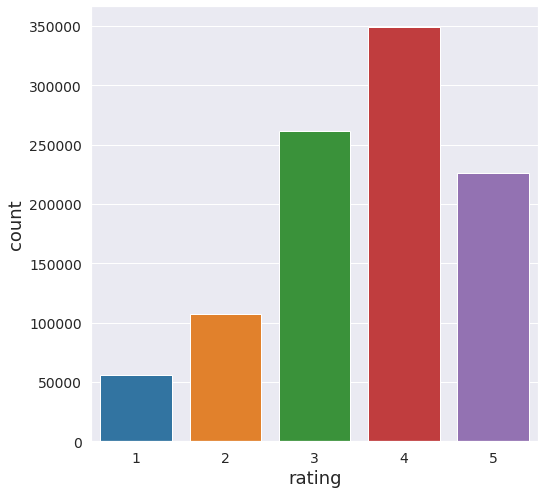

In [ ]:
# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize":14, 
                                "ytick.labelsize":14,
                                "axes.labelsize": 18,
                                "axes.titlesize": 20,
                                })

fig, ax = plt.subplots(1, 1, figsize=(8,8))

# To plot, we need to first transform our PySpark DataFrame into a Pandas DataFrame
ax = sns.countplot(x="rating", data=ratings_df.toPandas()) 

Load the dataframe with informations on movies and make some cool plots

In [ ]:
movies_df = spark.read.load(MOVIES_REMAPPED, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true")
movielens = ratings_df.join(movies_df, ["movieId"], "left")

movielens.show(5)
movielens.summary().show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|      0|     0|     5|978300760|One Flew Over the...|               Drama|
|      1|     0|     3|978302109|James and the Gia...|Animation|Childre...|
|      2|     0|     3|978301968| My Fair Lady (1964)|     Musical|Romance|
|      3|     0|     4|978300275|Erin Brockovich (...|               Drama|
|      4|     0|     5|978824291|Bug's Life, A (1998)|Animation|Childre...|
+-------+------+------+---------+--------------------+--------------------+
only showing top 5 rows

+-------+-----------------+------------------+------------------+--------------------+--------------------+-------+
|summary|          movieId|            userId|            rating|           timestamp|               title| genres|
+-------+-----------------+------------------+-------------

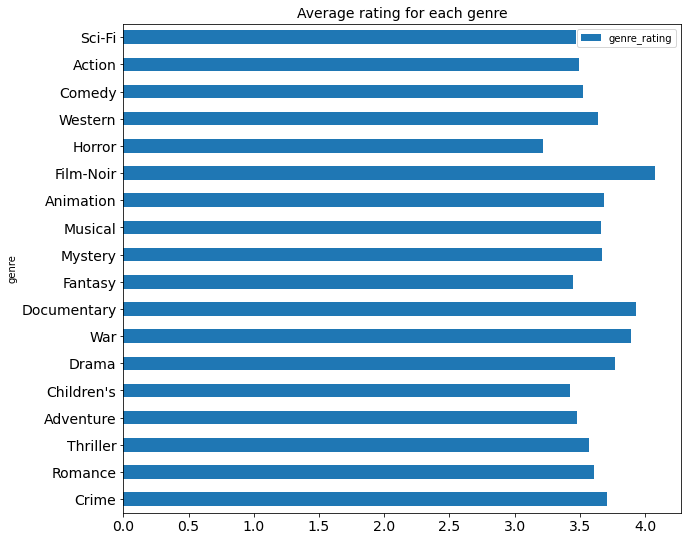

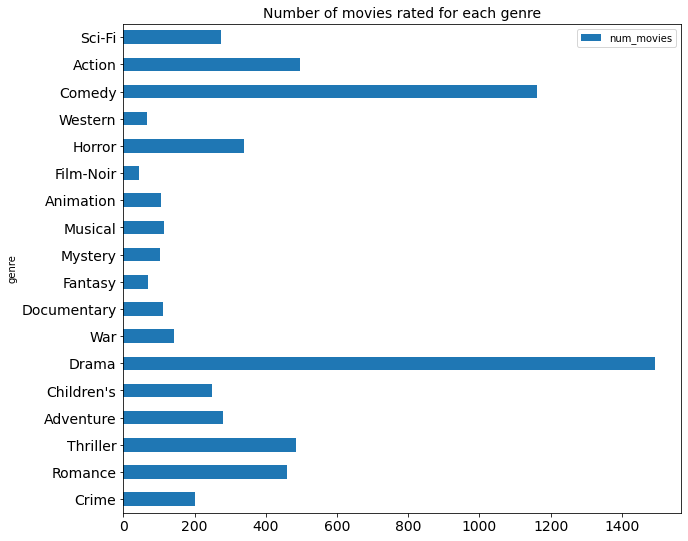

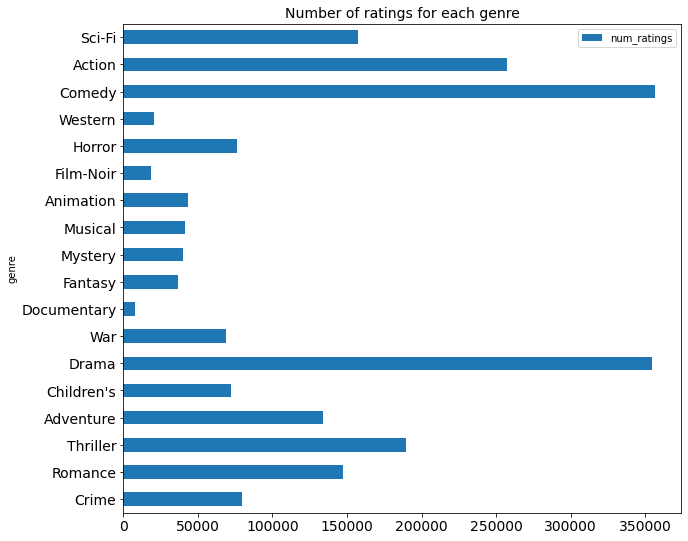

In [ ]:
# plot informations on genres
genres_grouped = (movielens.select("movieId", "userId", "genres", "rating")
                          .withColumn("genre", explode(split("genres", "\|"))) # from genres to new rows
                          .groupBy("genre").agg(mean(col("rating")).alias("genre_rating"), # each genre will have 3 columns
                                                countDistinct("movieId").alias("num_movies"),
                                                countDistinct("movieId","userId").alias("num_ratings")
                                                )
                    ).toPandas()

# make plots
genres_grouped.plot.barh("genre", "genre_rating", figsize=(10,9), fontsize=14)
plt.title("Average rating for each genre", {"fontsize": 14})

genres_grouped.plot.barh("genre", "num_movies", figsize=(10,9), fontsize=14)
plt.title("Number of movies rated for each genre", {"fontsize": 14})

genres_grouped.plot.barh("genre", "num_ratings", figsize=(10,9), fontsize=14)
plt.title("Number of ratings for each genre", {"fontsize": 14});

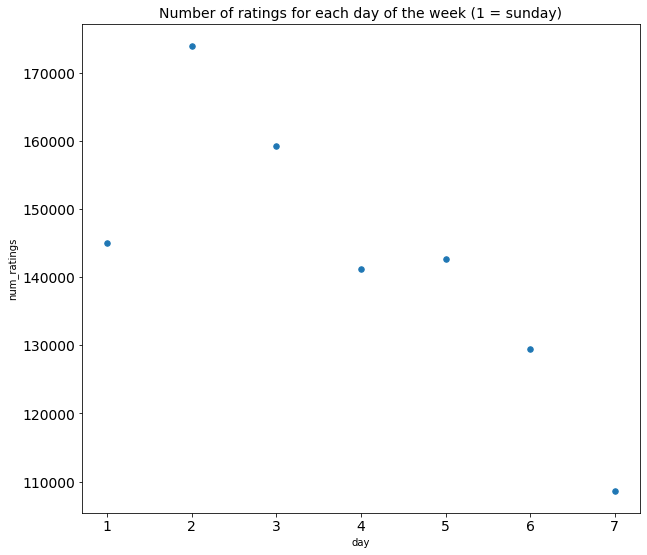

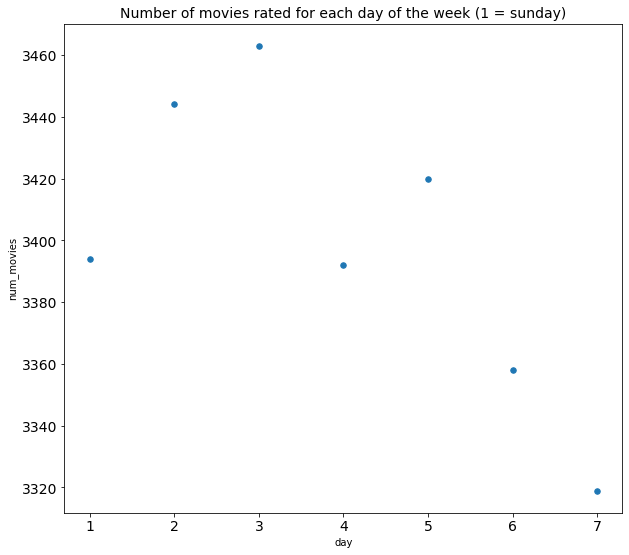

In [ ]:
# plot informations on days of the week
daily_infos = (movielens.withColumn("day", dayofweek(from_unixtime("timestamp").cast(DateType())))
                        .groupBy("day").agg(countDistinct("movieId").alias("num_movies"), # same last 2 columns as above
                                            countDistinct("movieId","userId").alias("num_ratings"))
                        ).toPandas()

# make plots
daily_infos.plot.scatter("day", "num_ratings", figsize=(10,9), fontsize=14, s=30)
plt.title("Number of ratings for each day of the week (1 = sunday)", {"fontsize": 14})

daily_infos.plot.scatter("day", "num_movies", figsize=(10,9), fontsize=14, s=30)
plt.title("Number of movies rated for each day of the week (1 = sunday)", {"fontsize": 14});

## Dataset Splitting: Training vs. Test Set

Before moving ahead, we drop the 'timestep' column and split our dataset into **2** portions:
- _training set_ (e.g., accounting for **80%** of the total number of instances);
- _test set_ (e.g., accounting for the remaining **20%** of instances)

From now on, we will be working on the training set portion only. The test set will come back into play when we evaluate our learned models. During the hyperparameters tuning phases, we will also create a validation set from the train set.

In [ ]:
ratings_df = ratings_df.drop("timestamp") # drop timestamp because useless
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED) # Randomly split our original dataset `user_item` into 80÷20 for training and test, respectively
print("Training set size: {:d} instances".format(train_df.count()))
print("Test set size: {:d} instances".format(test_df.count()))

Training set size: 800184 instances
Test set size: 200025 instances


# A New Collaborative Filtering Recommendation Algorithm Based on Dimensionality Reduction and Clustering Techniques

This is our implementation of the 1st [paper](https://ieeexplore.ieee.org/document/8355449).

First we need to build the user-item matrix from the dataset:

In [ ]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry
from pyspark.ml.linalg import SparseVector

user_item = CoordinateMatrix(train_df.rdd.map(lambda coords: MatrixEntry(*coords))) # build a matrix of 3D coordinates
user_item = user_item.toIndexedRowMatrix().rows.toDF(["userId", "ratings"]) # pass to user-item matrix
user_item = user_item.rdd.map(lambda x: (x[0], x[1].asML())).toDF(["userId", "ratings"]) # pass to DataFrame
gc.collect()

39

## **K-means clustering**

Let's find the best K to cluster the users, we will use the elbow method

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import Normalizer

def run_kmeans(dataset, n_clusters):
    """Runs the KMeans algorithm on the DataFrame dataset, with K = n_clusters"""
    
    features_col = "ratings"
    # Normalize inputs to unit-length vectors
    dataset = Normalizer(inputCol=features_col, outputCol=features_col+"_norm", p=1).transform(dataset)
    
    features_col += "_norm"
    # instantiate a KMeans model
    kmeans = KMeans(featuresCol=features_col,
                    predictionCol="cluster",
                    k=n_clusters,
                    initSteps=5,
                    maxIter=50,
                    distanceMeasure="cosine",
                    seed=RANDOM_SEED)
    model = kmeans.fit(dataset) # train

    
    clusters_df = model.transform(dataset) # predict

    return model, clusters_df


def evaluate_kmeans(clusters):
    """Evaluates clustering by computing Silhouette score"""

    evaluator = ClusteringEvaluator(distanceMeasure="cosine", featuresCol="ratings", predictionCol="cluster")
    return evaluator.evaluate(clusters)


def do_clustering(k_min, k_max, step):
    """Finds best number of clusters k between k_min and k_max, with given step size step"""
    
    clustering_results = {}
    
    for k in range(k_min, k_max + 1, step):
        print("Running K-means with K = {:d}, distance = cosine".format(k))
        model, clusters_df = run_kmeans(user_item, k)
        silhouette = evaluate_kmeans(clusters_df)
        ssd = model.summary.trainingCost
        print("Silhouette coefficient: {:.3f}".format(silhouette))
        print("Intra-cluster Sum of Squared Distances: {:.3f}".format(ssd))
        print()
        clustering_results[k] = (silhouette, ssd)
        
        # Free up memory space at the end of each iteration
        del model
        del clusters_df
        gc.collect()
        
    return clustering_results

clustering_results = do_clustering(10, 100, 10)

Running K-means with K = 10, distance = cosine
Silhouette coefficient: 0.034
Intra-cluster Sum of Squared Distances: 3627.443

Running K-means with K = 20, distance = cosine
Silhouette coefficient: 0.027
Intra-cluster Sum of Squared Distances: 3434.511

Running K-means with K = 30, distance = cosine
Silhouette coefficient: 0.026
Intra-cluster Sum of Squared Distances: 3353.490

Running K-means with K = 40, distance = cosine
Silhouette coefficient: 0.022
Intra-cluster Sum of Squared Distances: 3307.168

Running K-means with K = 50, distance = cosine
Silhouette coefficient: 0.020
Intra-cluster Sum of Squared Distances: 3256.687

Running K-means with K = 60, distance = cosine
Silhouette coefficient: 0.019
Intra-cluster Sum of Squared Distances: 3242.492

Running K-means with K = 70, distance = cosine
Silhouette coefficient: 0.018
Intra-cluster Sum of Squared Distances: 3215.596

Running K-means with K = 80, distance = cosine
Silhouette coefficient: 0.014
Intra-cluster Sum of Squared Dista

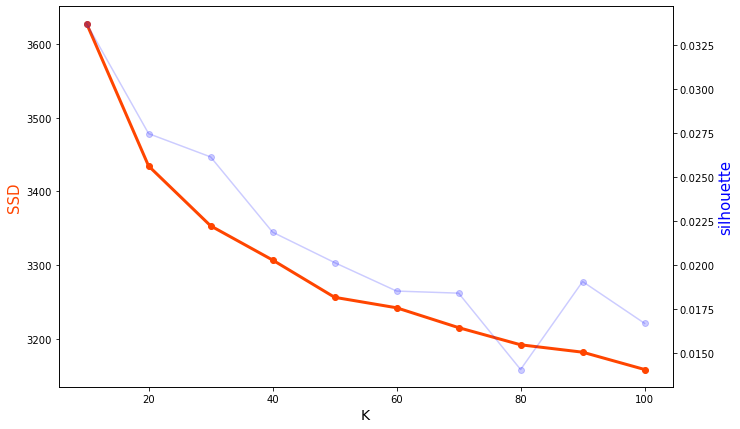

In [ ]:
def plot_clustering_results(clustering_results):
    # load the dictionary into pandas
    df = pd.DataFrame.from_dict(clustering_results, orient='index').reset_index()
    df.columns = ['K','Silhouette', 'SSD']

    # create figure and axis objects with subplots()
    fig, ax = plt.subplots(figsize=(11,7))
    
    # make a plot
    ax.plot(df.K, df.SSD, color="orangered", marker="o", lw=3)
    ax.set_xlabel("K", fontsize=14) # set x-axis label
    ax.set_ylabel("SSD", color="orangered", fontsize=15) # set y-axis label
    
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(df.K, df.Silhouette, color="blue", marker="o", alpha=0.2)
    ax2.set_ylabel("silhouette", color="blue", fontsize=15)
    plt.show()

plot_clustering_results(clustering_results)

We can see that more or less at K=50 there is the elbow point.

In [ ]:
BEST_K = 50
print("Running K-means using best K = {:d}".format(BEST_K))
model, clusters_df = run_kmeans(user_item, BEST_K)
clusters_df.cache()
clusters_df.groupBy("cluster").count().sort("cluster").show()

del model
gc.collect()

Running K-means using best K = 50
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  157|
|      1|  103|
|      2|  174|
|      3|  155|
|      4|   67|
|      5|   74|
|      6|   11|
|      7|   43|
|      8|   46|
|      9|   56|
|     10|  128|
|     11|  104|
|     12|   83|
|     13|  451|
|     14|   62|
|     15|  245|
|     16|   66|
|     17|  149|
|     18|  193|
|     19|  118|
+-------+-----+
only showing top 20 rows



345

## Hyperparameter tuning for the K-Means + ALS model

In [ ]:
from pyspark.ml.recommendation import ALS

def compute_clusters_mean(partitions):
    """compute the average of all the ratings for each cluster"""
    averages = dict()
    cluster_number = -1
    for df in partitions:
        cluster_number += 1
        averages[cluster_number] = df.select(mean('rating')).collect()[0]["avg(rating)"]
    return averages

def hyperparameter_tuning(df):
    """Useful function to automatize the process of hyperparameter tuning"""
    
    train_df, validation_df = df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)
    training_set = train_df.join(clusters_df.select('userId', 'cluster'), ['userId']) # join to have the cluster number in the training set
    validation_set = validation_df.join(clusters_df.select('userId', 'cluster'), ['userId']) # join to have the cluster number in the test set

    # divide each dataset in a list of K clusters, each cluster is a DataFrame
    train_partitions = []
    validation_partitions = []
    for i in range(BEST_K):
        train_partitions.append(training_set.filter(training_set.cluster == i))
        validation_partitions.append(validation_set.filter(validation_set.cluster == i))

    # now compute the mean for each cluster from the train set, and store it in the "centered_rating" columns
    clusters_averages = compute_clusters_mean(train_partitions)
    for i in range(len(train_partitions)):
        train_partitions[i] = train_partitions[i].withColumn("centered_rating", train_partitions[i].rating - clusters_averages[i])

    # let's start the grid search
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="ALS_based_prediction")
    ranks = [10, 25]
    regParams = [0.01, 0.1]
    maxIters = [5,10]
    configurations = []
    for rank in ranks:
        for regParam in regParams:
            for maxIter in maxIters:
                print("Evalutating for rank = {rank}, regParam = {regParam}, maxIter = {maxIter}".format(rank=rank, regParam=regParam, maxIter=maxIter))
                als = ALS(maxIter=maxIter, regParam=regParam, rank=rank, userCol="userId", itemCol="movieId", ratingCol="centered_rating", seed=RANDOM_SEED, coldStartStrategy="drop")
                models = []
                for df in train_partitions: # fit an ALS model for each cluster
                    model = als.fit(df)
                    models.append(model)
                
                # now validate the trained model
                df_predictions = models[0].transform(validation_partitions[0])
                df_predictions = df_predictions.withColumn("ALS_based_prediction", df_predictions.prediction + clusters_averages[0])
                for i in range(1, len(models)): # for each cluster of the validation set
                    df = models[i].transform(validation_partitions[i])
                    df = df.withColumn("ALS_based_prediction", df.prediction + clusters_averages[i])
                    df_predictions = df_predictions.union(df)

                # compute rmse and print
                rmse = evaluator.evaluate(df_predictions)
                configurations.append((rank, regParam, maxIter, rmse))
                print("Root Mean Squared Error = {:.5f}".format(rmse))
    
    # find the best model
    min_rmse = sorted(configurations, key=lambda x : x[3])
    print("The best hyperparameters are rank = {rank}, regParam = {regParam}, maxIter = {maxIter}".format(rank=min_rmse[0][0],regParam=min_rmse[0][1],maxIter=min_rmse[0][2]))     

    
hyperparameter_tuning(train_df)

Evalutating for rank = 10, regParam = 0.01, maxIter = 5
Root Mean Squared Error = 1.13742
Evalutating for rank = 10, regParam = 0.01, maxIter = 10
Root Mean Squared Error = 1.14589
Evalutating for rank = 10, regParam = 0.1, maxIter = 5
Root Mean Squared Error = 0.95064
Evalutating for rank = 10, regParam = 0.1, maxIter = 10
Root Mean Squared Error = 0.94645
Evalutating for rank = 25, regParam = 0.01, maxIter = 5
Root Mean Squared Error = 1.14671
Evalutating for rank = 25, regParam = 0.01, maxIter = 10
Root Mean Squared Error = 1.14676
Evalutating for rank = 25, regParam = 0.1, maxIter = 5
Root Mean Squared Error = 0.93749
Evalutating for rank = 25, regParam = 0.1, maxIter = 10
Root Mean Squared Error = 0.93527
The best hyperparameters are rank = 25, regParam = 0.1, maxIter = 10


## **K-means-ALS-based recommendation vs K-means-based recommendation**
In the paper the authors compare their method results with an approach based only on KMeans, so we do the same:

- The first one (the one they propose) leverages also Alternating Least Squares, a learning algorithm that we used to factorize the user-movie matrix into the product of two lower rank matrices: the user-factor matrix and the item-factor matrix.
ALS operates by alternately fixing (i.e. assuming constant) one latent vector (e.g. item vector) and updating the other one (e.g. user vector).
<br/>We fit one Matrix Factorization model through ALS for each cluster (identified by K-means), then we use every model to transform the corresponding partitions of the test set which, of course, are equal to the number of clusters. This approach also sums as a bias the average of all the ratings in a cluster to make the final prediction;

- The second one is based only on K-means and does not make use of other techniques. After the partition of the users into clusters, it predicts the user's review of a specific film by computing the average of the reviews of that film given by all the other users in the same cluster.

In [ ]:
# let's define a bunch of utility functions
from pyspark.ml.linalg import SparseVector, DenseVector

def sparse_to_array(v):
    """transform a sparse vector to a dense vector"""
    v = DenseVector(v)
    new_array = list([float(x) for x in v])
    return new_array

def is_review_done(row):
    """return a list with 1 if the i-th movie is reviewed, 0 otherwise"""
    return [1 if x > 0 else 0 for x in row]

def get_RMSE(df, labelCol, predictionCol):
    """given a dataframe, compute the Root Mean Squared Error"""
    evaluator = RegressionEvaluator(metricName="rmse", labelCol=labelCol, predictionCol=predictionCol)
    return evaluator.evaluate(df)

Again we divide the whole train dataframe in clusters. Same goes for the test set (using the clusters we found with the train set because, of course, we can't peek the train set). Then we store the average review for each cluster and we compare the two K-means based approaches.

In [ ]:
ALS_RMSE = []
k_means_RMSE = []

# collect the RMSE of the two approaches for different values of K on the real test set
for k in range(10, 51, 10):
    print("Evaluating the performances using K = {:d}".format(k))

    ########## K-Means-ALS model ##########
    model, clusters_df = run_kmeans(user_item, k)
    clusters_df.cache()
    del model
    training_set = train_df.join(clusters_df.select('userId', 'cluster'), ['userId']) # join to have the cluster number in the training set
    test_set = test_df.join(clusters_df.select('userId', 'cluster'), ['userId']) # join to have the cluster number in the test set

    # lists of cluster dataframes
    train_partitions = [] 
    test_partitions = [] 
    for i in range(k):
        train_partitions.append(training_set.filter(training_set.cluster == i))
        test_partitions.append(test_set.filter(test_set.cluster == i))
    
    # compute means
    clusters_averages = compute_clusters_mean(train_partitions)
    for i in range(len(train_partitions)):
        train_partitions[i] = train_partitions[i].withColumn("centered_rating", train_partitions[i].rating - clusters_averages[i])
    del training_set, test_set
    gc.collect()

    models = []
    # build the recommendation models using ALS on the training data with the best found hyperparameters
    als = ALS(maxIter=10, rank=25, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="centered_rating", seed=RANDOM_SEED, coldStartStrategy="drop")
    for df in train_partitions: # one model for each cluster
        model = als.fit(df)
        models.append(model)
    del train_partitions
    gc.collect()

    # use the fitted models to make predictions on the real test set
    df_predictions = models[0].transform(test_partitions[0])
    df_predictions = df_predictions.withColumn("ALS_based_prediction", df_predictions.prediction + clusters_averages[0])
    for i in range(1, len(models)):
        df = models[i].transform(test_partitions[i])
        df = df.withColumn("ALS_based_prediction", df.prediction + clusters_averages[i])
        df_predictions = df_predictions.union(df) # concatenate the predictions of each cluster to get a single dataframe
    del test_partitions, models, clusters_averages
    gc.collect()
    
    # compute rmse and print
    ALS_RMSE.append(get_RMSE(df_predictions, "rating", "ALS_based_prediction"))
    print("K-means-ALS-based-recommendation Root Mean Squared Error = {:.5f}".format(ALS_RMSE[-1]))

    ########## K-Means model ##########
    sparse_to_array_udf = udf(sparse_to_array, T.ArrayType(T.FloatType()))
    is_review_done_udf = udf(is_review_done, T.ArrayType(T.IntegerType()))
    clusters_df_dense = clusters_df.withColumn('features_array', sparse_to_array_udf("ratings")).drop("ratings").drop("ratings_norm") # a column that contains the dense array of reviews
    clusters_df_dense = clusters_df_dense.withColumn('reviews_done', is_review_done_udf('features_array')) # a column that contains 1 if movie has been rated by that user, 0 otherwise
    
    # sum_ratings is, for each cluster, an array that will contain in the i-th position the sum of all reviews of the users in that cluster for the i-th movie
    # sum_number_ratings is, for each cluster, an array that will contain in the i-th position the number of reviews given by the users in that cluster for the i-th movie
    sums = clusters_df_dense.groupBy('cluster')\
                    .agg(array(*[sum(col('features_array')[i]) for i in range(3706)]).alias("sum_ratings"),
                         array(*[sum(col('reviews_done')[i]) for i in range(3706)]).alias("sum_number_ratings"))\
                    .orderBy('cluster')\
                    .select(['sum_ratings','sum_number_ratings'])\
                    .collect()
    del clusters_df_dense
    gc.collect()
    
    df_k_means_pred = [] # list of tuples of the form (true rating, our prediction)
    for row in df_predictions.rdd.collect():
        num = sums[row.cluster][0][row.movieId]
        if num != 0: # exclude the movies for which we don't have any review (COLD START PROBLEM)
            df_k_means_pred.append((row.rating, num/sums[row.cluster][1][row.movieId]))
    
    # compute rmse and print
    k_means_RMSE.append(get_RMSE(spark.createDataFrame(df_k_means_pred, ["rating","prediction"]), "rating", "prediction"))
    print("K-means-based-recommendation Root Mean Squared Error = {:.5f}".format(k_means_RMSE[-1]))
    
    del df_k_means_pred, sums
    gc.collect()

Evaluating the performances using K = 10
K-means-ALS-based-recommendation Root Mean Squared Error = 0.89869
K-means-based-recommendation Root Mean Squared Error = 0.98587
Evaluating the performances using K = 20
K-means-ALS-based-recommendation Root Mean Squared Error = 0.91937
K-means-based-recommendation Root Mean Squared Error = 0.99454
Evaluating the performances using K = 30
K-means-ALS-based-recommendation Root Mean Squared Error = 0.92366
K-means-based-recommendation Root Mean Squared Error = 0.99691
Evaluating the performances using K = 40
K-means-ALS-based-recommendation Root Mean Squared Error = 0.92723
K-means-based-recommendation Root Mean Squared Error = 1.00114
Evaluating the performances using K = 50
K-means-ALS-based-recommendation Root Mean Squared Error = 0.93385
K-means-based-recommendation Root Mean Squared Error = 1.00486


We finally plot the Root Mean Squared Error obtained by analyzing the results of the two different approaches in order to compare their performance.

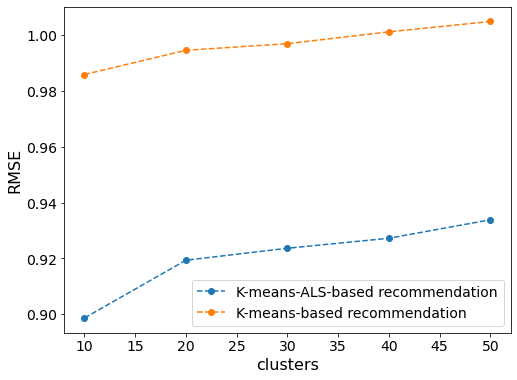

In [ ]:
_, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('clusters', fontsize=16)
ax.set_ylabel('RMSE', fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(range(10,51,10), ALS_RMSE, linestyle='--', marker='o', label="K-means-ALS-based recommendation")
ax.plot(range(10,51,10), k_means_RMSE, linestyle='--', marker='o',label="K-means-based recommendation")
ax.legend(loc="lower right", prop={'size': 14})
plt.show()

# Neural Collaborative Filtering

This is our implementation of the 2nd [paper](https://dl.acm.org/doi/10.1145/3038912.3052569).

First of all they propose a simple MLP for modeling user-item interaction and predict a recommendation:
![MLP](https://miro.medium.com/max/1400/1*sTBtqrsQzTKlZ8hSU7I6FQ.png)

Note that they use this approach to predict a binary classification problem (item **i** recommended/not recommended for the user **u**) while we are modifying their approach to predict on a multi-class classification problem (predict an integer rating from 1 to 5), which is of course an harder task.

In [ ]:
from pyspark.ml.feature import OneHotEncoder
# transform our targets into one-hot vectors, to easily compute the cross-entropy loss

onehot = OneHotEncoder(inputCol="rating", outputCol="labels", dropLast=False) 
train_df = train_df.withColumn("rating", train_df.rating - 1) # subtract 1 because indices range from 0 to 4
test_df = test_df.withColumn("rating", test_df.rating - 1)
onehot_model = onehot.fit(train_df)

train_df = onehot_model.transform(train_df)
test_df = onehot_model.transform(test_df)
train_df = train_df.withColumn("rating", train_df.rating + 1) # add 1 back
test_df = test_df.withColumn("rating", test_df.rating + 1)

train_df.show(5)
test_df.show(5)

+------+-------+------+-------------+
|userId|movieId|rating|       labels|
+------+-------+------+-------------+
|     0|      0|     5|(5,[4],[1.0])|
|     0|      1|     3|(5,[2],[1.0])|
|     0|      3|     4|(5,[3],[1.0])|
|     0|      4|     5|(5,[4],[1.0])|
|     0|      5|     3|(5,[2],[1.0])|
+------+-------+------+-------------+
only showing top 5 rows

+------+-------+------+-------------+
|userId|movieId|rating|       labels|
+------+-------+------+-------------+
|     0|      2|     3|(5,[2],[1.0])|
|     0|      6|     5|(5,[4],[1.0])|
|     0|     11|     4|(5,[3],[1.0])|
|     0|     12|     4|(5,[3],[1.0])|
|     0|     13|     4|(5,[3],[1.0])|
+------+-------+------+-------------+
only showing top 5 rows



In [ ]:
# fix the seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

# we define our neural model
class MLP(torch.nn.Module):
    """Our implementation of the Neural Collaborative Filtering model"""
    
    def __init__(self,
                num_users,
                num_items,
                dimension_mlp,
                layers_mlp):
        super(MLP, self).__init__()
        
        # multilayer perceptron embeddings
        self.user_mlp = nn.Embedding(num_users, dimension_mlp)
        self.item_mlp = nn.Embedding(num_items, dimension_mlp)
        
        # linear layers
        input_dim = dimension_mlp * 2
        self.fc_layers = nn.ModuleList()
        for layer in range(layers_mlp):
            self.fc_layers.append(nn.Linear(input_dim, input_dim//2)) # half the dimension of the data at each linear layer
            input_dim = input_dim//2

        self.output = nn.Linear(input_dim, 5) # final output layer
        
        self.relu = nn.ReLU() # activation function for nonlinearity
        self.dropout = nn.Dropout(0.3) # dropout to allow better generalization

    def forward(self, user_id, item_id):
        
        user_id, item_id = user_id.long(), item_id.long()
        
        # multilayer perceptron embeddings
        user_embedding_mlp = self.user_mlp(user_id)
        item_embedding_mlp = self.item_mlp(item_id)

        mlp_out = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=1) # concatenate user and item embeddings

        for idx in range(len(self.fc_layers)):
            mlp_out = self.fc_layers[idx](mlp_out)
            mlp_out = self.relu(mlp_out)
        mlp_out = self.dropout(mlp_out)

        output = self.output(mlp_out)
        return output

## Hyperparameter tuning for the MLP model

Of course, there are a lot of possible hyperparameters to tune in a neural network architecture, but since we are running this part of the notebook on Google Colab (we don't have access to powerful computational resources) and it is really time consuming, we limit ourselves to a few hyperparameters. Also, 20 epochs are chosen to shorten the training time otherwise Colab will crash.

First we define a useful function to plot the training loss. Note that we take a validation set to compute the metrics after each model's training, this will allow us to choose the best hyperparameters.

In [ ]:
def plot_loss(training_history, title):
    """useful function to create a plot of the training loss"""

    # create a unique dictionary
    results = {"epoch":[], "train_loss":[]}
    for dic in training_history:
        results["epoch"].append(dic["epoch"])
        results["train_loss"].append(dic["train"]["loss"])

    # load the dictionary into pandas
    df = pd.DataFrame.from_dict(results)

    # create figure and axis objects with subplots()
    fig, ax = plt.subplots(figsize=(11,7))
    
    # make a plot
    ax.plot(df.epoch, df.train_loss, marker="o", label="Training loss")
    ax.legend(loc="upper right", prop={'size': 15}) # show the legend
    ax.set_xlabel("X", fontsize=15) # set x-axis label
    ax.set_ylabel("CELoss", fontsize=15) # set y-axis label
    ax.set_title(title) # set the title
    plt.show()

# argmax function to extract predictions from logits
argmax = udf(lambda v: float(np.argmax(v) + 1), returnType=T.DoubleType()) # + 1 because indices range from 0 to 4, but ratings are from 1 to 5

# define the two evaluators 
evaluatorAcc = MulticlassClassificationEvaluator(predictionCol="predictions", labelCol="rating", metricName="accuracy")
evaluatorRMSE = RegressionEvaluator(predictionCol="predictions", labelCol="rating", metricName="rmse")

/usr/local/lib/python3.7/dist-packages/horovod/spark/common/util.py:513: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train_data_schema)
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_f

[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_1658596712[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpmguf5rr4 to dir file:///content/hvdstore/runs/pytorch_16585967

[e61dec0430b3:02430] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


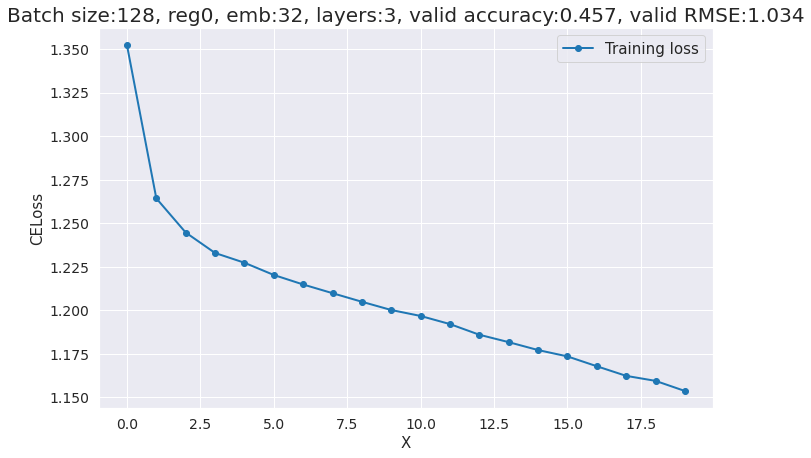

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp4ajjird8 to dir file:///content/hvdstore/runs/pytorch_1658598023[1,0]<stdout

[e61dec0430b3:03034] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


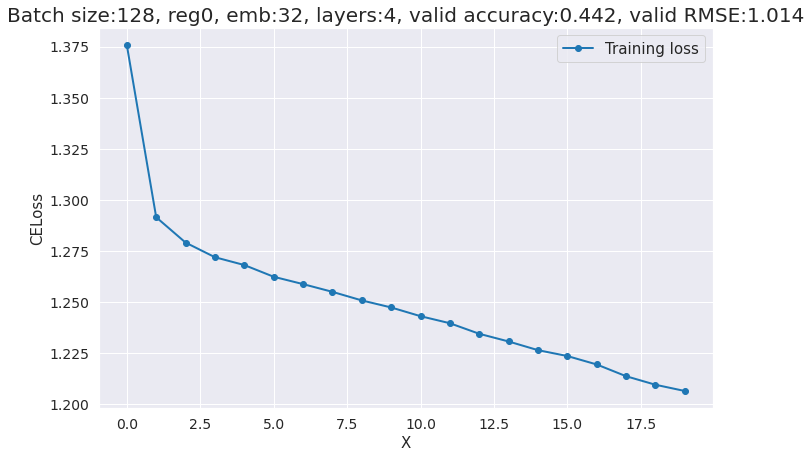

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpzjgeeadr to dir file:///content/hvdstore/runs/pytorch_1658599342[1,0]<stdout

[e61dec0430b3:03510] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


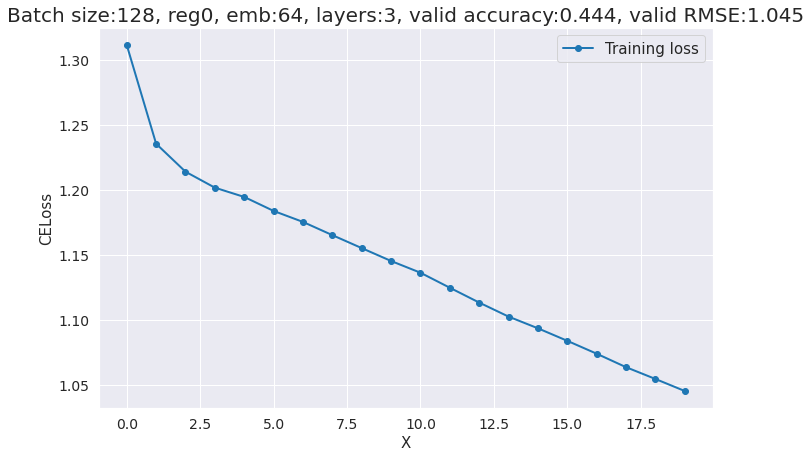

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp8nf0eaay to dir file:///content/hvdstore/runs/pytorch_1658601218[1,0]<stdout

[e61dec0430b3:03941] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


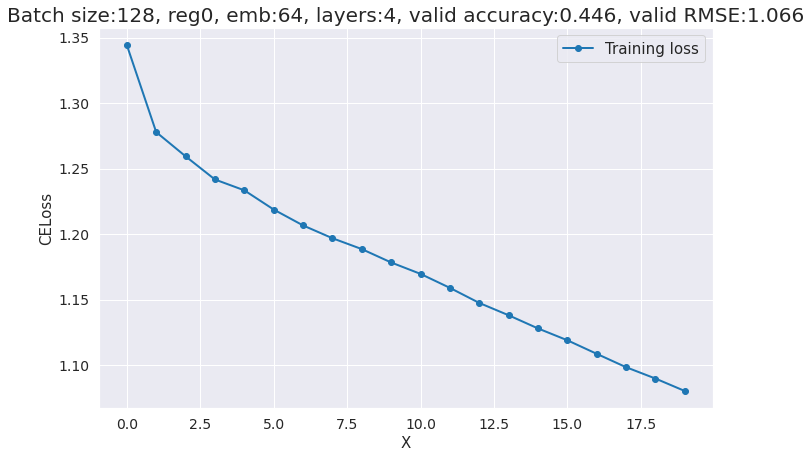

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx3zg to dir file:///content/hvdstore/runs/pytorch_1658603181
[1,0]<stdout>:Syncing dir /tmp/tmpz6gzx

[e61dec0430b3:04275] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


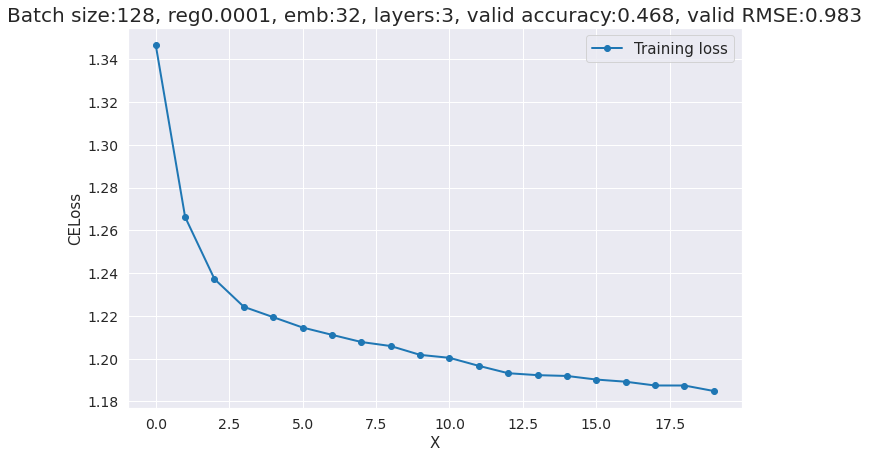

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpf95t49pz to dir file:///content/hvdstore/runs/pytorch_1658604522[1,0]<stdout>:
[1,0]<stdou

[e61dec0430b3:04697] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


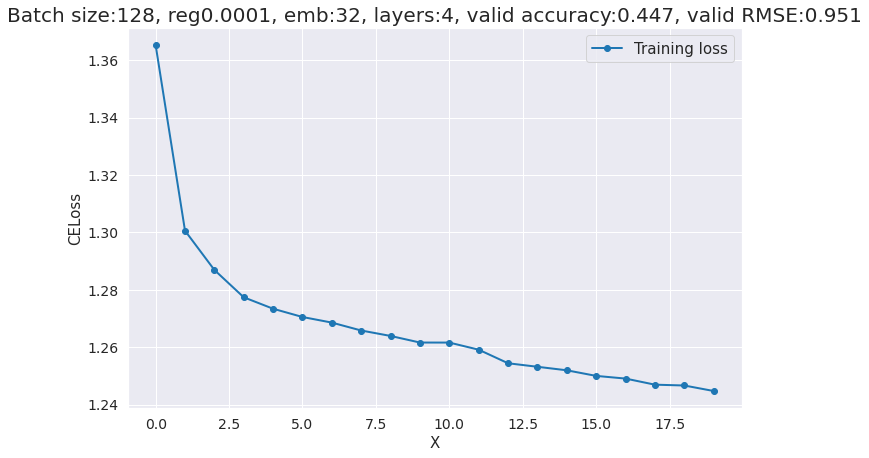

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3tmvmhm8 to dir file:///content/hvdstore/runs/pytorch_1658606052[1,0]<stdout>:
[1,0]<stdou

[e61dec0430b3:05283] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


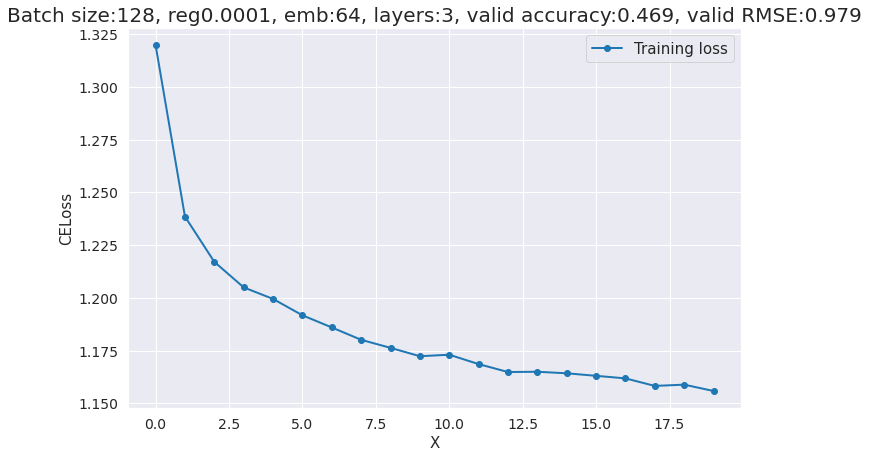

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpbd6xxgfw to dir file:///content/hvdstore/runs/pytorch_1658608392[1,0]<stdout

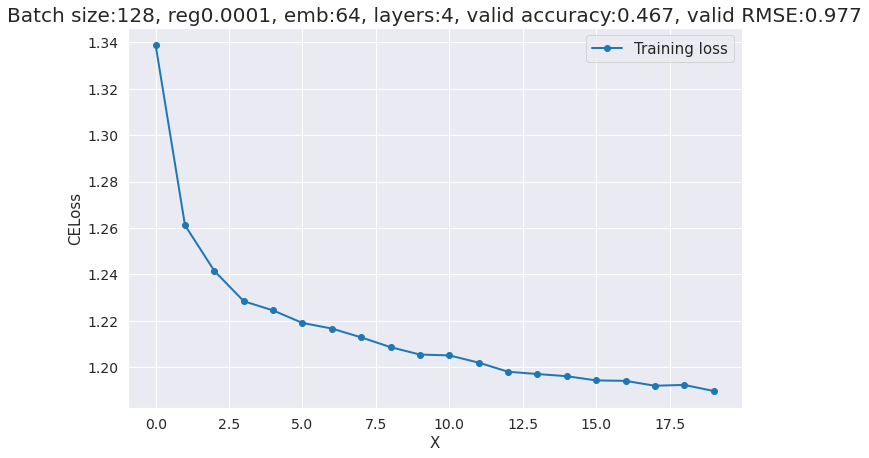

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/pytorch_1658610891[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp9q6ysbsi to dir file:///content/hvdstore/runs/p

[e61dec0430b3:06959] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


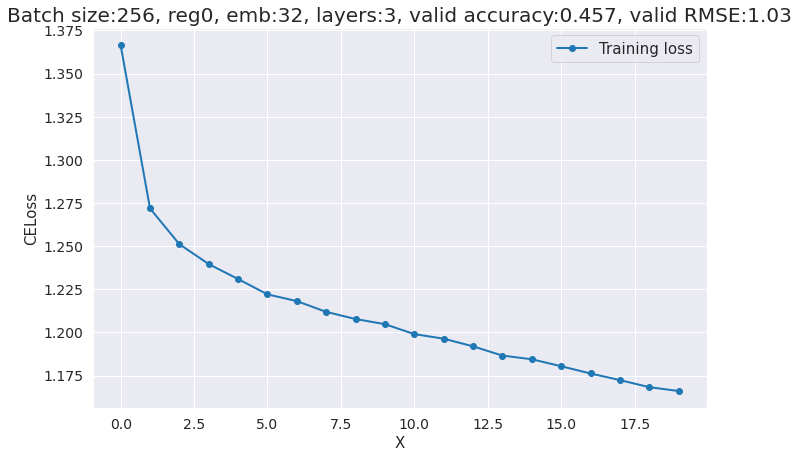

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpwv_xu4l1 to dir file:///content/hvdstore/runs/pytorch_1658611610[1,0]<stdout>:
[1,0]<stdou

[e61dec0430b3:07338] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


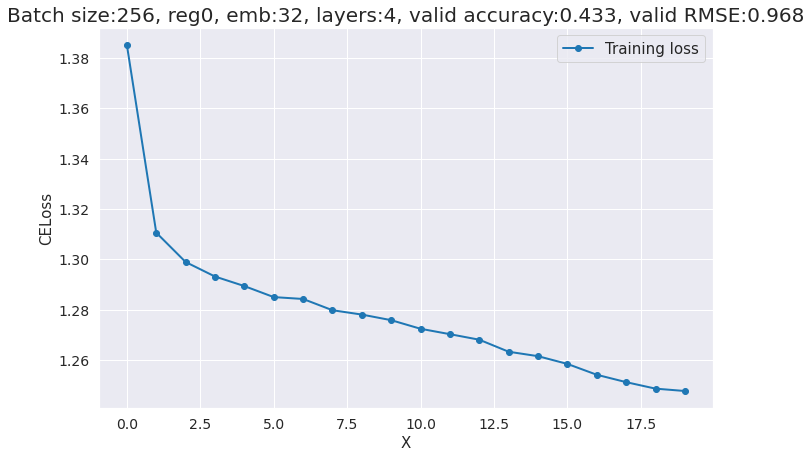

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359
[1,0]<stdout>:Syncing dir /tmp/tmpglvwqxwz to dir file:///content/hvdstore/runs/pytorch_1658612359[1,0]<stdout>:
[1,0]<stdout>:Syncing dir

[e61dec0430b3:07714] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


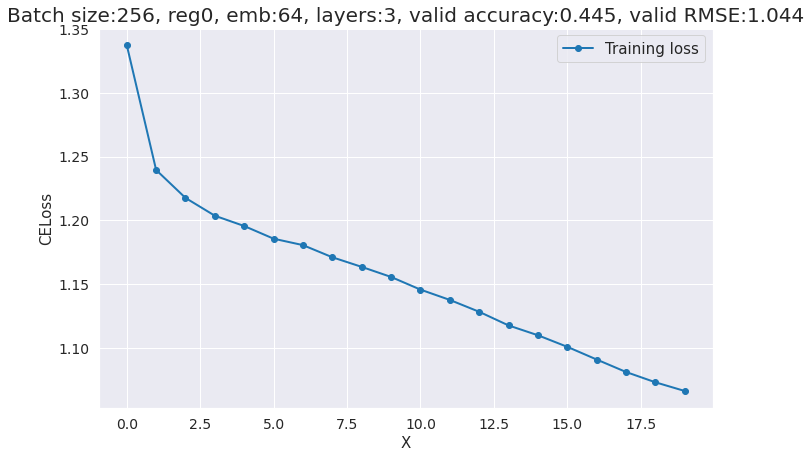

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpludr018u to dir file:///content/hvdstore/runs/pytorch_1658613361[1,0]<stdout>:
[1,0]<stdou

[e61dec0430b3:08089] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


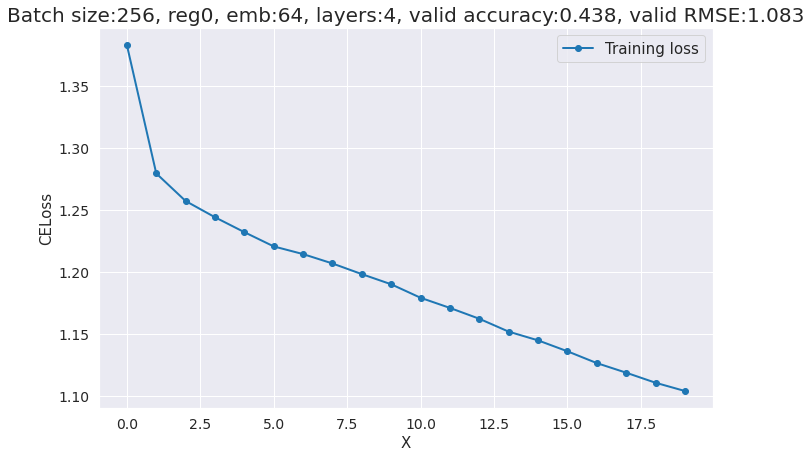

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpyiq8ii8n to dir file:///content/hvdstore/runs/pytorch_1658614345[1,0]<stdout>:
[1,0]<stdout>:Syncing dir

[e61dec0430b3:08465] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


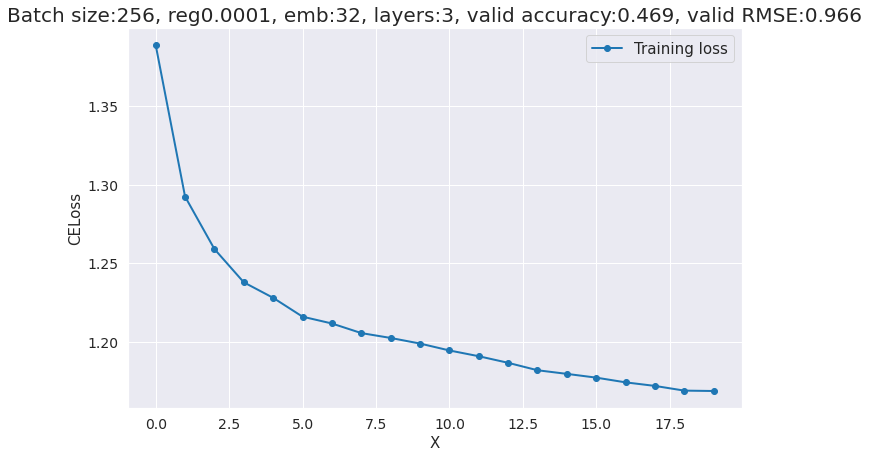

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpc3b14jlh to dir file:///content/hvdstore/runs/pytorch_1658615100
[1,0]<stdou

[e61dec0430b3:08843] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


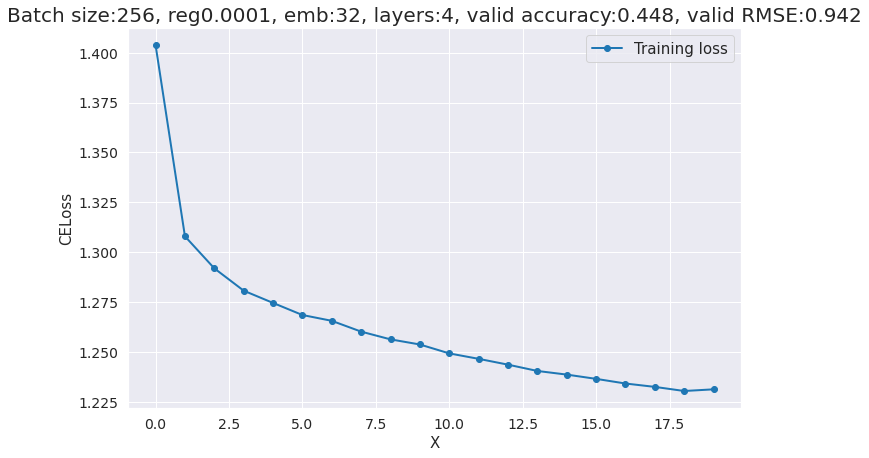

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_1658615935[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp_h8z1cti to dir file:///content/hvdstore/runs/pytorch_16586159

[e61dec0430b3:09223] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


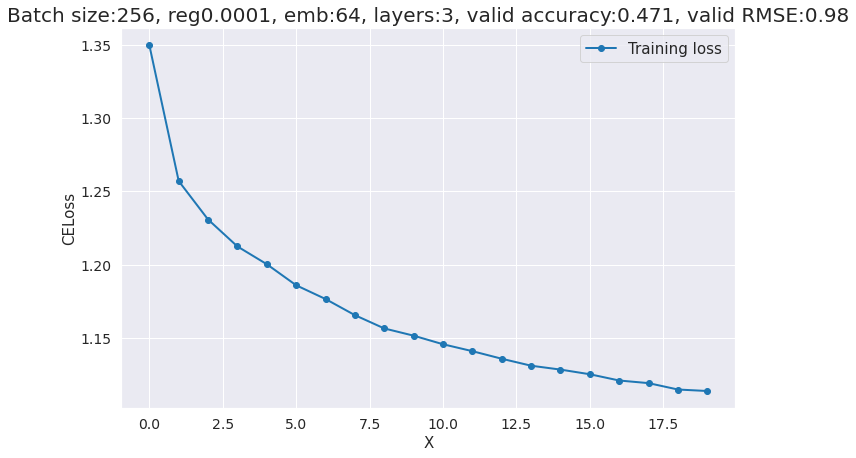

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpt35ug54f to dir file:///content/hvdstore/runs/pytorch_1658617116[1,0]<stdout>:
[1,0]<stdou

[e61dec0430b3:09662] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


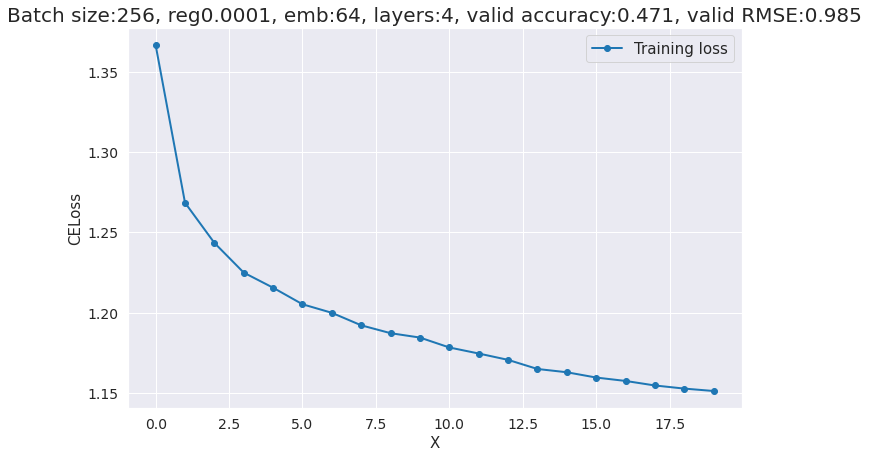

In [ ]:
# take a validation set
train_df, valid_df = train_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

# create a dataframe to store hyperparameter tuning results
columns = ["batch_size", "L2_regularization", "embedding_size", "#_layers", "valid_acc", "valid_RMSE"]
vals = []

# grid search for hyperparameter tuning
for batch_size in [128, 256]:
    for reg in [0.0, 0.0001]:
        for emb_size in [32, 64]:
            for layers in [3, 4]:

                MLP_model = MLP(ratings_df.select("userId").distinct().count(),
                            ratings_df.select("movieId").distinct().count(),
                            emb_size,
                            layers) # define the model
                MLP_optim = torch.optim.Adam(MLP_model.parameters(), lr=0.001, weight_decay=reg) # define the optimizer
                loss = nn.CrossEntropyLoss() # define the loss

                # thanks to the Horovod library, we can train a neural network on a PySpark environment
                MLP_estim = hvd.TorchEstimator(store=Store.create("./hvdstore"),
                                                model=MLP_model,
                                                optimizer=MLP_optim,
                                                loss=lambda inp, truth: loss(inp, truth.float()),
                                                input_shapes=[[-1], [-1]],
                                                feature_cols=["userId", "movieId"],
                                                label_cols=["labels"],
                                                batch_size=batch_size,
                                                epochs=20,
                                                random_seed=RANDOM_SEED,
                                                use_gpu=False,
                                                verbose=0) # define the nn estimator

                trained_MLP_model = MLP_estim.fit(train_df).setOutputCols(["predictions"]) # train the nn

                # evaluate the nn on a validation set
                pred = trained_MLP_model.transform(valid_df)
                pred = pred.withColumn("predictions", argmax(pred.predictions))
                acc = evaluatorAcc.evaluate(pred)
                rmse = evaluatorRMSE.evaluate(pred)

                vals.append((batch_size, reg, emb_size, layers, acc, rmse))
                plot_loss(trained_MLP_model.getHistory(),
                          "Batch size:" + str(batch_size) + ", reg" + str(reg) + 
                          ", emb:" + str(emb_size) + ", layers:" + str(layers) +
                          ", valid accuracy:" + str(round(acc, 3)) +
                          ", valid RMSE:" + str(round(rmse, 3))) # plot training loss and other infos
                print()

hyper_results = spark.createDataFrame(vals, columns)

In [ ]:
hyper_results.show(50, truncate=False)

+----------+-----------------+--------------+--------+-------------------+------------------+
|batch_size|L2_regularization|embedding_size|#_layers|valid_acc          |valid_RMSE        |
+----------+-----------------+--------------+--------+-------------------+------------------+
|128       |0.0              |32            |3       |0.45667664333212277|1.0341252584453486|
|128       |0.0              |32            |4       |0.4421624735451392 |1.0141942783253217|
|128       |0.0              |64            |3       |0.44444166155310383|1.0450510954819905|
|128       |0.0              |64            |4       |0.4461197450314954 |1.0662558588867268|
|128       |1.0E-4           |32            |3       |0.4676593240078645 |0.9825089223260277|
|128       |1.0E-4           |32            |4       |0.44699635580378944|0.9511834618435765|
|128       |1.0E-4           |64            |3       |0.46936245350832156|0.9787992199834507|
|128       |1.0E-4           |64            |4       |0.4672

So, considering the validation RMSE as the main metric, it turns out that the model with batch size = 256, L2 regularization = 0.0001, MLP's embedding size = 32 and 4 layers is the best. We retrain it on both train and validation data, and then test on the held-out test set.

##MLP model evaluation

/usr/local/lib/python3.7/dist-packages/horovod/spark/common/util.py:513: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train_data_schema)
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_f

[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprfc9hvdr to dir file:///content/hvdstore/runs/pytorch_1658695163
[1,0]<stdout>:Syncing dir /tmp/tmprfc9h

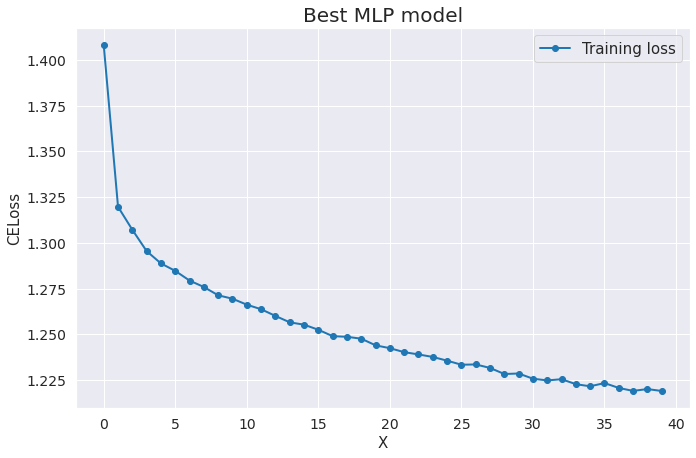

+------+-------+------+-------------+-----------+
|userId|movieId|rating|       labels|predictions|
+------+-------+------+-------------+-----------+
|     0|      2|     3|(5,[2],[1.0])|        5.0|
|     0|      6|     5|(5,[4],[1.0])|        4.0|
|     0|     11|     4|(5,[3],[1.0])|        4.0|
|     0|     12|     4|(5,[3],[1.0])|        5.0|
|     0|     13|     4|(5,[3],[1.0])|        4.0|
+------+-------+------+-------------+-----------+
only showing top 5 rows

Test Accuracy: 0.431281089863767
Test RMSE: 0.9751518522046414


In [ ]:
# Retrain the best model on the whole train data we had
train_df = train_df.union(valid_df)

# define all we need
MLP_model = MLP(ratings_df.select("userId").distinct().count(),
            ratings_df.select("movieId").distinct().count(),
            32,
            4)
MLP_optim = torch.optim.Adam(MLP_model.parameters(), lr=0.001, weight_decay=0.0001) 
loss = nn.CrossEntropyLoss()

MLP_estim = hvd.TorchEstimator(store=Store.create("./hvdstore"),
                                model=MLP_model,
                                optimizer=MLP_optim,
                                loss=lambda inp, truth: loss(inp, truth.float()),
                                input_shapes=[[-1], [-1]],
                                feature_cols=["userId", "movieId"],
                                label_cols=["labels"],
                                batch_size=256,
                                epochs=40,
                                random_seed=RANDOM_SEED,
                                use_gpu=False,
                                verbose=0)

# train the model and plot the loss
trained_MLP_model = MLP_estim.fit(train_df).setOutputCols(["predictions"])
plot_loss(trained_MLP_model.getHistory(), "Best MLP model")

# use it on the test set
pred = trained_MLP_model.transform(test_df)
pred = pred.withColumn("predictions", argmax(pred.predictions))
pred.show(5)

# evaluate it and print metrics
print('Test Accuracy:', evaluatorAcc.evaluate(pred))
print('Test RMSE:', evaluatorRMSE.evaluate(pred))

Then, after demonstrating that Matrix Factorization is just a special case of their NCF framework, they propose a final version of the model, which includes both MF and the previous MLP approach. It is called NeuMF (Neural Matrix Factorization):
![NeuMF](https://nipunbatra.github.io/blog/images/neumf.png)

In [ ]:
# we define our neural model
class NeuMF(torch.nn.Module):
    """Our implementation of the Neural Collaborative Filtering model"""
    
    def __init__(self,
                num_users,
                num_items,
                dimension_mlp,
                dimension_mf,
                layers_mlp):
        super(NeuMF, self).__init__()
        
        # multilayer perceptron embeddings
        self.user_mlp = nn.Embedding(num_users, dimension_mlp)
        self.item_mlp = nn.Embedding(num_items, dimension_mlp)
        
        # matrix factorization embeddings
        self.user_mf = nn.Embedding(num_users, dimension_mf)
        self.item_mf = nn.Embedding(num_items, dimension_mf)
        
        # linear layers
        input_dim = dimension_mlp * 2
        self.fc_layers = nn.ModuleList()
        for layer in range(layers_mlp):
            self.fc_layers.append(nn.Linear(input_dim, input_dim//2)) # half the dimension of the data at each linear layer
            input_dim = input_dim//2

        self.output = nn.Linear(input_dim + dimension_mf, 5) # final output layer
        
        self.relu = nn.ReLU() # activation function for nonlinearity
        self.dropout = nn.Dropout(0.3) # dropout to allow better generalization

    def forward(self, user_id, item_id):
        
        user_id, item_id = user_id.long(), item_id.long()
        
        # multilayer perceptron embeddings
        user_embedding_mlp = self.user_mlp(user_id)
        item_embedding_mlp = self.item_mlp(item_id)

        mlp_out = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=1) # concatenate mlp embeddings

        for idx in range(len(self.fc_layers)):
            mlp_out = self.fc_layers[idx](mlp_out)
            mlp_out = self.relu(mlp_out)
        mlp_out = self.dropout(mlp_out)

        # matrix factorization
        user_embedding_mf = self.user_mf(user_id)
        item_embedding_mf = self.item_mf(item_id)
        mf_out = torch.mul(user_embedding_mf, item_embedding_mf) # pointwise multiplication of mf embeddings
        mf_out = self.dropout(mf_out)
        
        output = self.output(torch.cat([mlp_out, mf_out], dim=1)) # concatenate the two branches results and project onto the final layer
        return output

##Hyperparameter tuning for the NeuMF model

We now use the best found hyperparameters for the MLP part, and just search for the best embedding size of the MF part and the best optimizer's hyperparameters.

/usr/local/lib/python3.7/dist-packages/horovod/spark/common/util.py:513: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train_data_schema)
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_f

[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir file:///content/hvdstore/runs/pytorch_1658777523[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp2646ef07 to dir fil

[de3b4a0b4a60:02496] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


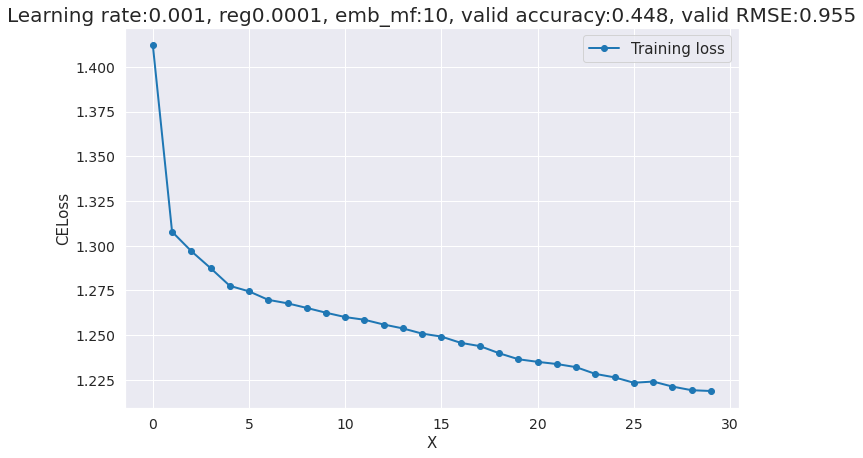

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177
[1,0]<stdout>:Syncing dir /tmp/tmpn538n5d1 to dir file:///content/hvdstore/runs/pytorch_1658779177[1,0]<stdout>:
[1,0]<stdout>:Syncing dir

[de3b4a0b4a60:03130] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


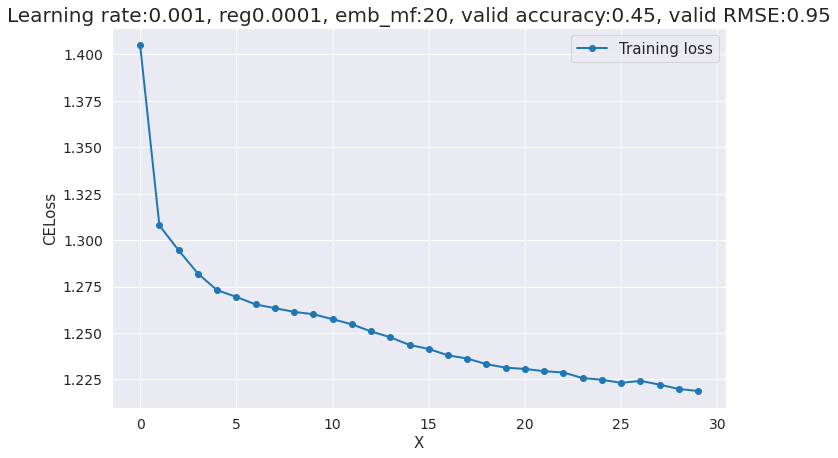

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp0e6f2r83 to dir file:///content/hvdstore/runs/pytorch_1658781191[1,0]<stdout

[de3b4a0b4a60:03921] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


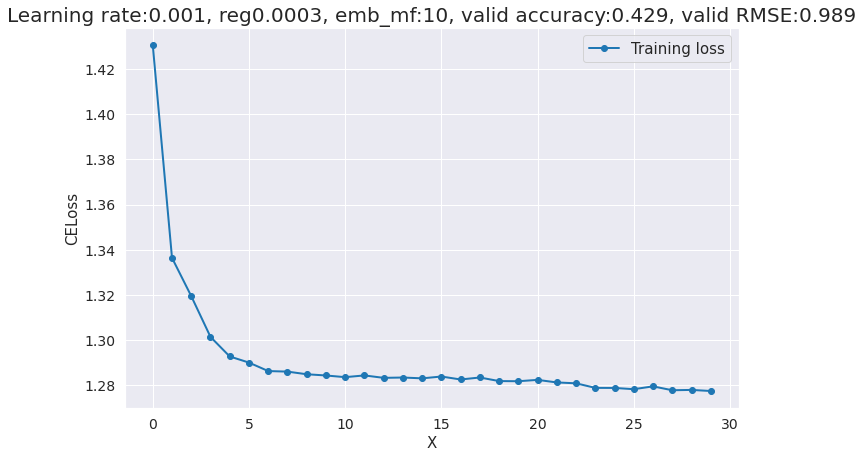

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_1658782729[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp6jafjzge to dir file:///content/hvdstore/runs/pytorch_16587827

[de3b4a0b4a60:04619] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


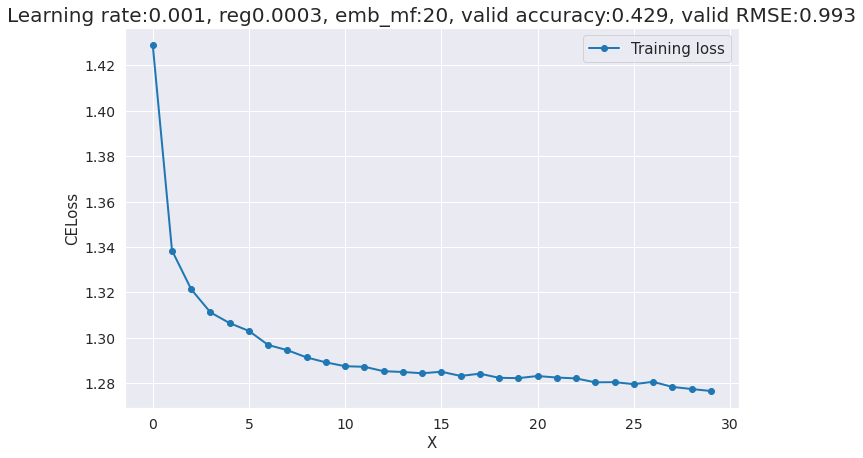

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprtxovhyr to dir file:///content/hvdstore/runs/pytorch_1658784486[1,0]<stdout>:
[1,0]<stdou

[de3b4a0b4a60:05300] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


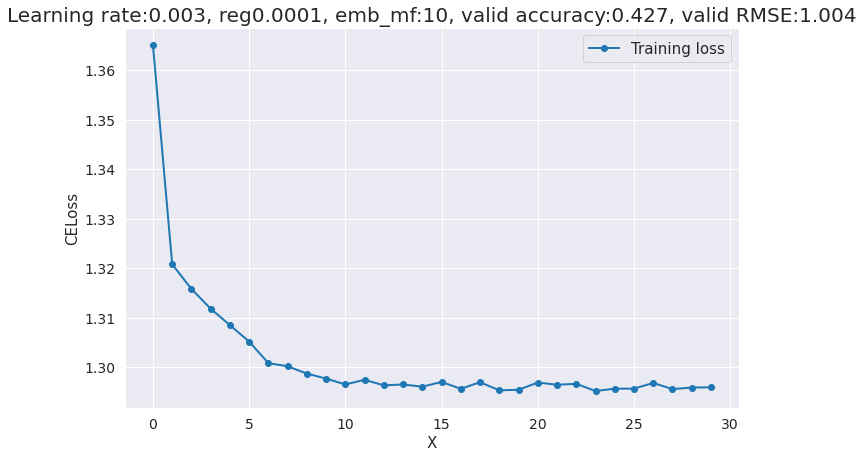

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp3rexv69_ to dir file:///content/hvdstore/runs/pytorch_1658786063[1,0]<stdout

[de3b4a0b4a60:05990] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


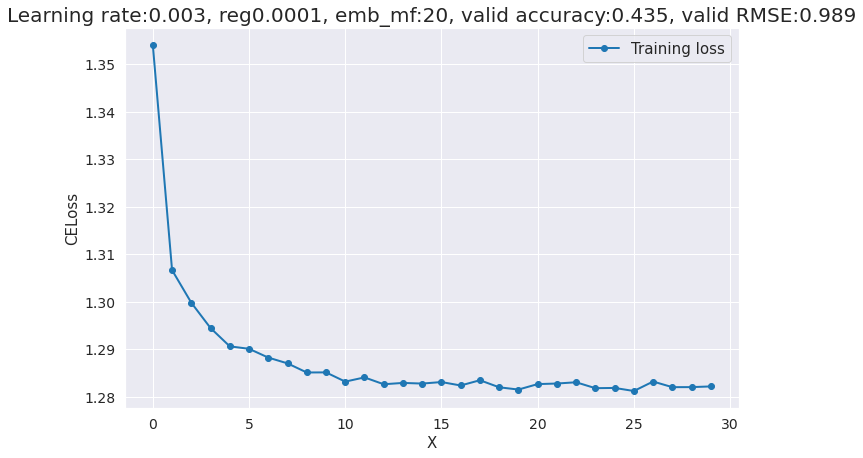

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmp7wyu_3zd to dir file:///content/hvdstore/runs/pytorch_1658787852[1,0]<stdout>:
[1,0]<stdout>:Syncing dir

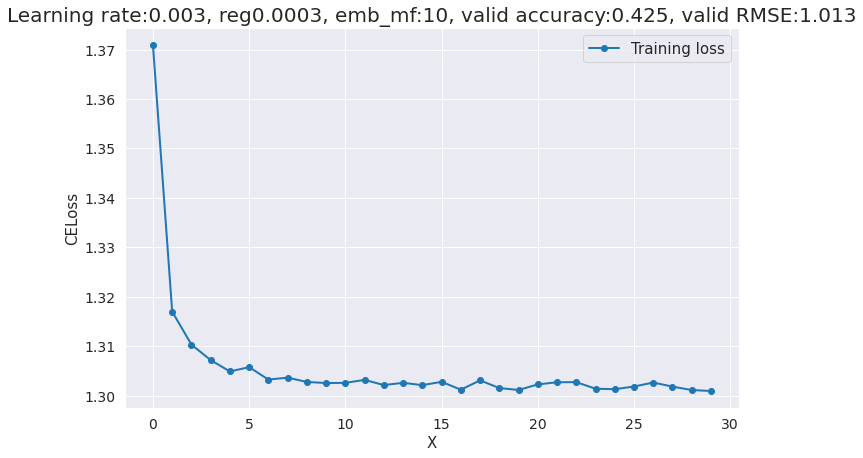

[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_fn(v)
[1,0]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem

[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_1658789422[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmpke2qlwal to dir file:///content/hvdstore/runs/pytorch_16587894

[de3b4a0b4a60:07361] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


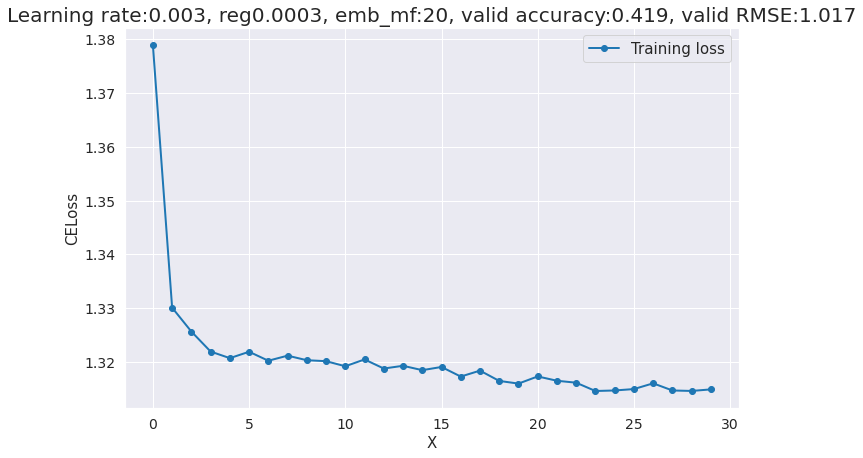

In [ ]:
# take a validation set
train_df, valid_df = train_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

# create a dataframe to store hyperparameter tuning results
columns = ["MF_embedding_size", "learning_rate", "L2_regularization", "valid_acc", "valid_RMSE"]
vals = []

# grid search for hyperparameter tuning
for lr in [0.001, 0.003]:
    for reg in [0.0001, 0.0003]:
        for emb_size_mf in [10, 20]:

            NeuMF_model = NeuMF(ratings_df.select("userId").distinct().count(),
                        ratings_df.select("movieId").distinct().count(),
                        32,
                        emb_size_mf,
                        4) # define the model
            NeuMF_optim = torch.optim.Adam(NeuMF_model.parameters(), lr=lr, weight_decay=reg) # define the optimizer
            loss = nn.CrossEntropyLoss() # define the loss

            NeuMF_estim = hvd.TorchEstimator(store=Store.create("./hvdstore"),
                                            model=NeuMF_model,
                                            optimizer=NeuMF_optim,
                                            loss=lambda inp, truth: loss(inp, truth.float()),
                                            input_shapes=[[-1], [-1]],
                                            feature_cols=["userId", "movieId"],
                                            label_cols=["labels"],
                                            batch_size=256,
                                            epochs=30,
                                            random_seed=RANDOM_SEED,
                                            use_gpu=False,
                                            verbose=0) # define the nn estimator

            trained_NeuMF_model = NeuMF_estim.fit(train_df).setOutputCols(["predictions"]) # train the nn

            # evaluate the nn on a validation set
            pred = trained_NeuMF_model.transform(valid_df)
            pred = pred.withColumn("predictions", argmax(pred.predictions))
            acc = evaluatorAcc.evaluate(pred)
            rmse = evaluatorRMSE.evaluate(pred)

            vals.append((emb_size_mf, lr, reg, acc, rmse))
            plot_loss(trained_NeuMF_model.getHistory(),
                      "Learning rate:" + str(lr) + ", reg" + str(reg) + 
                      ", emb_mf:" + str(emb_size_mf) +
                      ", valid accuracy:" + str(round(acc, 3)) +
                      ", valid RMSE:" + str(round(rmse, 3))) # plot training loss and other infos
            print()

hyper_results = spark.createDataFrame(vals, columns)

In [ ]:
hyper_results.show(50, truncate=False)

+-----------------+-------------+-----------------+-------------------+------------------+
|MF_embedding_size|learning_rate|L2_regularization|valid_acc          |valid_RMSE        |
+-----------------+-------------+-----------------+-------------------+------------------+
|10               |0.001        |1.0E-4           |0.44823613389603395|0.9552430051578416|
|20               |0.001        |1.0E-4           |0.45007701651785154|0.949608855502042 |
|10               |0.001        |3.0E-4           |0.4292512491703505 |0.9889943259264501|
|20               |0.001        |3.0E-4           |0.4293514332586127 |0.9930001841437348|
|10               |0.003        |1.0E-4           |0.42722252138304134|1.0040430210594584|
|20               |0.003        |1.0E-4           |0.4349867882233604 |0.9887473789014234|
|10               |0.003        |3.0E-4           |0.4252814546729616 |1.012544512721327 |
|20               |0.003        |3.0E-4           |0.41908256421173906|1.0172395989333143|

The model with learning rate = 0.001, L2 regularization = 0.0001 and MF's embedding size = 20 is the best (again according to the RMSE). We retrain it on both train and validation data, and then test on the held-out test set.

## NeuMF model evaluation

/usr/local/lib/python3.7/dist-packages/horovod/spark/common/util.py:513: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train_data_schema)
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.7/dist-packages/petastorm/pytorch.py:339: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
[1,1]<stderr>:  row_as_dict[k] = self.transform_f

[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout>:
[1,0]<stdout>:Syncing dir /tmp/tmprhxy4ldi to dir file:///content/hvdstore/runs/pytorch_1658849640[1,0]<stdout

[a419b9d4ef47:02298] PMIX ERROR: BAD-PARAM in file src/dstore/pmix_esh.c at line 491


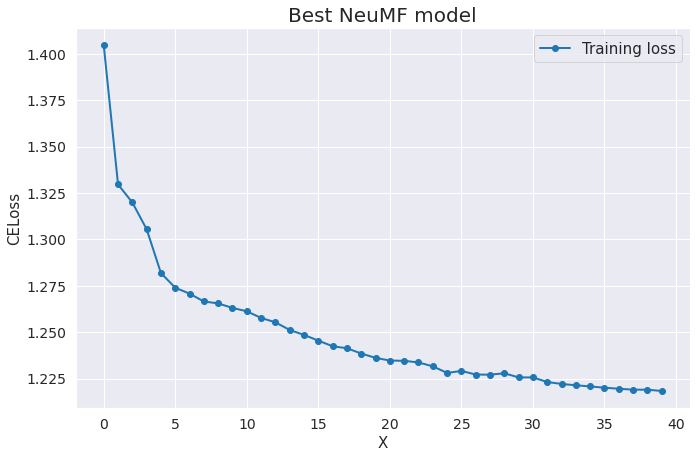

+------+-------+------+-------------+-----------+
|userId|movieId|rating|       labels|predictions|
+------+-------+------+-------------+-----------+
|     0|      2|     3|(5,[2],[1.0])|        4.0|
|     0|      6|     5|(5,[4],[1.0])|        4.0|
|     0|     11|     4|(5,[3],[1.0])|        4.0|
|     0|     12|     4|(5,[3],[1.0])|        4.0|
|     0|     13|     4|(5,[3],[1.0])|        4.0|
+------+-------+------+-------------+-----------+
only showing top 5 rows

Test Accuracy: 0.45068366454193226
Test RMSE: 0.9444646622890192


In [ ]:
# Retrain the best model on the whole train data 
train_df = train_df.union(valid_df)

# define all we need
NeuMF_model = NeuMF(ratings_df.select("userId").distinct().count(),
            ratings_df.select("movieId").distinct().count(),
            32,
            20,
            4)
NeuMF_optim = torch.optim.Adam(NeuMF_model.parameters(), lr=0.001, weight_decay=0.0001) 
loss = nn.CrossEntropyLoss()

NeuMF_estim = hvd.TorchEstimator(store=Store.create("./hvdstore"),
                                model=NeuMF_model,
                                optimizer=NeuMF_optim,
                                loss=lambda inp, truth: loss(inp, truth.float()),
                                input_shapes=[[-1], [-1]],
                                feature_cols=["userId", "movieId"],
                                label_cols=["labels"],
                                batch_size=256,
                                epochs=40,
                                random_seed=RANDOM_SEED,
                                use_gpu=False,
                                verbose=0)

# train the model and plot the loss
trained_NeuMF_model = NeuMF_estim.fit(train_df).setOutputCols(["predictions"])
plot_loss(trained_NeuMF_model.getHistory(), "Best NeuMF model")

# use it on the test set
pred = trained_NeuMF_model.transform(test_df)
pred = pred.withColumn("predictions", argmax(pred.predictions))
pred.show(5)

# evaluate it and print metrics
print('Test Accuracy:', evaluatorAcc.evaluate(pred))
print('Test RMSE:', evaluatorRMSE.evaluate(pred))

# Conclusions

Model | Test RMSE
------ | ------
K-Means | 0.986
**K-Means-ALS** | **0.899**
MLP | 0.975
NeuMF | 0.945

For each paper we re-implemented the two approaches proposed. With regard to the first one, we compared a weaker approach based only on K-Means and a more advanced one with K-Means + ALS (proposed by the authors), which performs better. For the second paper, we compared two different neural network approaches: the MLP and the NeuMF, the last one is an enhanced version of the MLP model. As we can see from the table above the K-Means-ALS is the approach that performs better than all reaching an RMSE of 0.899, followed by the NeuMF with an RMSE of 0.945. Is interesting to see that a classical but "clever" approach can still outperform a neural network, which is a more complicated model. Of course we are making some assumptions (e.g. we use the neural approach to perform multi-class classification meanwhile the authors perform binary classification), but still we managed to get some good results.